# CIFAR-10 Image Classification using CNN (Convolutional Network) in PyTorch


# Necessary Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import CIFAR10
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split, ConcatDataset
from torchvision import transforms
import torchvision.transforms as tt

# Metrics
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
import itertools


In [2]:
stats = ([0.4914, 0.4822, 0.4465],[0.2023, 0.1994, 0.2010])
train_transform = tt.Compose([
    tt.RandomHorizontalFlip(),
    tt.ToTensor(),
    tt.Normalize(*stats)
])

test_transform = tt.Compose([
    tt.ToTensor(),
    tt.Normalize(*stats)
])

# Loading Data

In [3]:
train_data = CIFAR10(download=True, root="./data", transform=train_transform)
test_data = CIFAR10(root="./data", train=False, transform=test_transform)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data


_____

In [4]:
train_classes_items = dict()

for train_item in train_data:
    label = train_data.classes[train_item[1]]
    if label not in train_classes_items:
        train_classes_items[label] = 1
    else:
        train_classes_items[label] += 1

train_classes_items

{'frog': 5000,
 'truck': 5000,
 'deer': 5000,
 'automobile': 5000,
 'bird': 5000,
 'horse': 5000,
 'ship': 5000,
 'cat': 5000,
 'dog': 5000,
 'airplane': 5000}

In [5]:
test_classes_items = dict()
for test_item in test_data:
    label = test_data.classes[test_item[1]]
    if label not in test_classes_items:
        test_classes_items[label] = 1
    else:
        test_classes_items[label] += 1

test_classes_items

{'cat': 1000,
 'ship': 1000,
 'airplane': 1000,
 'frog': 1000,
 'automobile': 1000,
 'truck': 1000,
 'dog': 1000,
 'horse': 1000,
 'deer': 1000,
 'bird': 1000}

## Samples from Cifar-10
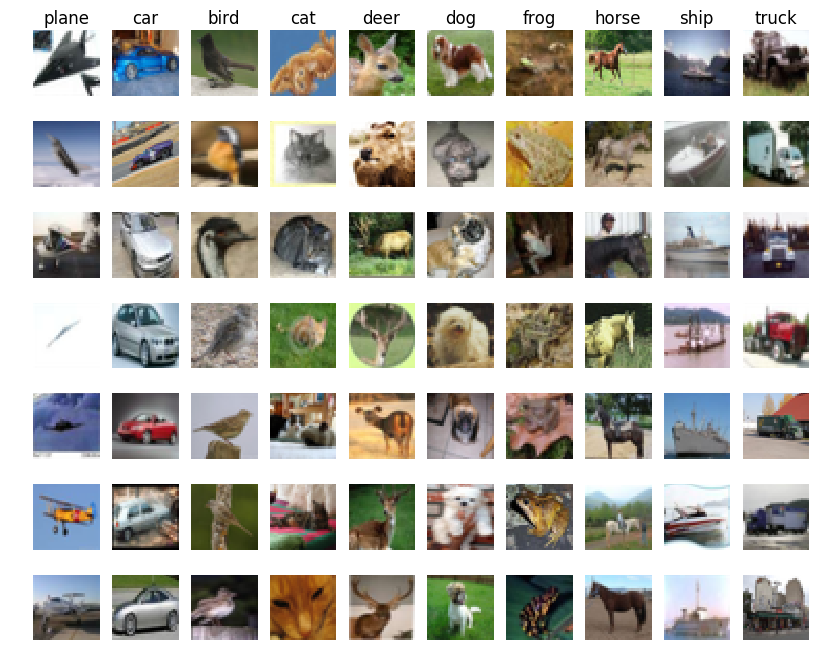

# BATCHSIZE & DataLoader

In [6]:
BATCH_SIZE = 128
train_dl = DataLoader(train_data, BATCH_SIZE, num_workers=2, pin_memory=True, shuffle=True)
test_dl = DataLoader(test_data, BATCH_SIZE, num_workers=2, pin_memory=True, shuffle=False)

# Visualization

/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


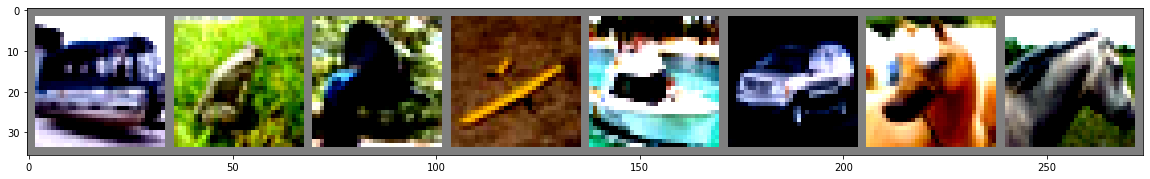

ship          frog          bird          airplane      ship          automobile    horse         horse         


In [7]:
# for 8 images
train_8_samples = DataLoader(train_data, 8, num_workers=4, pin_memory=True, shuffle=True)

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.figure(figsize = (20,20))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(train_8_samples)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print(''.join(f'{train_data.classes[labels[j]]:14s}' for j in range(8)))

# Get CUDA ready

In [8]:
def get_device():
    if torch.cuda.is_available():
        return torch.device("cuda")
    return torch.device("cpu")

def to_device(data,device):
    if isinstance(data,(list,tuple)):
        return [to_device(x,device) for x in data]
    return data.to(device,non_blocking=True)


class ToDeviceLoader:
    def __init__(self,data,device):
        self.data = data
        self.device = device
        
    def __iter__(self):
        for batch in self.data:
            yield to_device(batch,self.device)
            
    def __len__(self):
        return len(self.data)


In [9]:
device = get_device()
print(device)

train_dl = ToDeviceLoader(train_dl, device)
test_dl = ToDeviceLoader(test_dl, device)

cuda


# Helper function to visualize predictions

In [10]:
def plot_training_metrics(train_hist, model, test_data, y_actual, y_pred, classes, model_name):
    """
    Input: trained model history, model, test image generator, actual and predicted labels, class list
    Output: Plots loss vs epochs, accuracy vs epochs, confusion matrix
    """
    fpr, tpr, thresholds = metrics.roc_curve(y_actual, y_pred, pos_label=9)
    AUC       = metrics.auc(fpr, tpr)*100
    Acc       = accuracy_score(y_actual, y_pred)*100 
    results_title =(f"\n Model AUC {AUC:.2f}%, Accuracy {Acc:.2f}% on Test Data\n")
    print(results_title.format(AUC, Acc))

    
    # print classification report
    print(classification_report(y_actual, y_pred, target_names=classes))

    # extract data from training history for plotting
    loss_values     = [x.get("train_loss") for x in history]
    val_loss_values = [x["val_loss"] for x in history]
    val_acc_values  = [x["val_acc"] for x in history]    
   

    # get the min loss and max accuracy for plotting
    min_loss = np.min(val_loss_values)
    
    # create plots
    plt.subplots(figsize=(12,4))
    
    # plot loss by epochs
    plt.subplot(1,3,1)
    plt.plot(loss_values, 'bo', label = 'Training loss')
    plt.plot(val_loss_values, 'cornflowerblue', label = 'Validation loss')
    plt.title('Validation Loss by Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.axhline(y=min_loss,color='darkslategray', linestyle='--')
    plt.legend()

    # plot accuracy by epochs
    plt.subplot(1,3,2)
    plt.plot(val_acc_values, 'cornflowerblue', label = 'Validation Accuracy')
    plt.title('Validation Accuracy by Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('AUC')
    plt.legend()

    
     # calculate Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)

    # create confusion matrix plot
    plt.subplot(1,3,3)
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.BuPu)
    plt.title(f"Confusion Matrix \nAUC: {AUC:.2f}%")
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    # loop through matrix, plot each 
    threshold = cm.max() / 2.
    for r, c in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(c, r, format(cm[r, c], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[r, c] > threshold else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.savefig(f"{model_name}.pdf")

    plt.show()

In [11]:
@torch.no_grad()
def get_all_preds(model, loader):
    all_preds = torch.tensor([])
    for batch in loader:
        images, labels = batch

        preds = model(images)
        all_preds = torch.cat((all_preds, preds) ,dim=0)

    return all_preds

In [12]:
def accuracy(predicted, actual):
    _, predictions = torch.max(predicted, dim=1)
    return torch.tensor(torch.sum(predictions==actual).item()/len(predictions))

# CNN

In [13]:
class BaseModel(nn.Module):
    def training_step(self,batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out,labels)
        return loss
    
    def validation_step(self,batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out,labels)
        acc = accuracy(out,labels)
        return {"val_loss":loss.detach(),"val_acc":acc}
    
    def validation_epoch_end(self,outputs):
        batch_losses = [loss["val_loss"] for loss in outputs]
        loss = torch.stack(batch_losses).mean()
        batch_accuracy = [accuracy["val_acc"] for accuracy in outputs]
        acc = torch.stack(batch_accuracy).mean()
        return {"val_loss":loss.item(),"val_acc":acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

In [14]:
# Creating a CNN class
class CNN(BaseModel):
	#  Determine what layers and their order in CNN object 
    def __init__(self, num_classes):
        super(CNN, self).__init__()
        self.conv_layer1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5, padding='same')
        self.conv_layer2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, padding='same')
        self.max_pool1 = nn.MaxPool2d(kernel_size = 2, stride = 2) 
        
        self.conv_layer3 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=5, padding='same')
        self.conv_layer4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=5, padding='same')
        self.conv_layer5 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=5, padding='same')
        self.max_pool2 = nn.MaxPool2d(kernel_size = 2, stride = 2) 
    
        self.fc1 = nn.Linear(1024, 128)
        self.fc2 = nn.Linear(128, num_classes)
                
        self.relu1 = nn.ReLU()
        self.flatten = nn.Flatten()
        #self.dropout = nn.Dropout(0.5)

    
    # Progresses data across layers    
    def forward(self, x):
        #CNN Layer 1
        out = self.conv_layer1(x)
        out = self.relu1(out)
        
        #CNN Layer 2
        out = self.conv_layer2(out)
        out = self.relu1(out)
        out = self.max_pool1(out)
        #out = self.dropout(out)

        #CNN Layer 3
        out = self.conv_layer3(out)
        out = self.relu1(out)
        out = self.max_pool2(out)
        
        #CNN Layer 3
        out = self.conv_layer3(out)
        out = self.relu1(out)
        #out = self.dropout(out)
        
        #CNN Layer 4
        out = self.conv_layer4(out)
        out = self.relu1(out)
        
        #CNN Layer 5
        out = self.conv_layer5(out)
        out = self.relu1(out)
        out = self.max_pool2(out)

        #Out layers
        out = out.reshape(out.size(0), -1)
        #out = self.dropout(out)

        out = self.flatten(out)
        out = self.fc1(out)
        out = self.relu1(out)
        out = self.fc2(out)
        return out

# Hyperparameters

- **max_lr**: is the maximum learning rate that we set for learning rate scheduler. For the learning rate scheduler we used OneCycleLR, which sets the learning rate to a low learning rate, gradually increases it to the max learning rate then goes back to a low learning rate. <br/>
- **grad_clip**: prevents the gradients to become too large. <br/>
- **weight_decay**: essentially tries to make the model simple and helps the model generalise better.


In [15]:
epochs = 20
optimizer = torch.optim.Adam
max_lr = 1e-3
grad_clip = 0.1
weight_decay = 1e-5
scheduler = torch.optim.lr_scheduler.OneCycleLR
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
num_classes = len(classes)

In [16]:
model = CNN(num_classes)
criterion = nn.CrossEntropyLoss()
total_step = len(train_dl)
model = to_device(model, device)

# Evaluation & Fit Function for Training

In [17]:
@torch.no_grad()
def evaluate(model,test_dl):
    model.eval()
    outputs = [model.validation_step(batch) for batch in test_dl]
    return model.validation_epoch_end(outputs)

In [18]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit (epochs, train_dl, test_dl, model, optimizer, max_lr, weight_decay, scheduler, grad_clip=None):
    torch.cuda.empty_cache()
    
    history = []
    
    optimizer = optimizer(model.parameters(), max_lr, weight_decay = weight_decay)

    scheduler = scheduler(optimizer, max_lr, epochs=epochs, steps_per_epoch=len(train_dl))
    
    for epoch in range(epochs):
        model.train()
        
        train_loss = []
        lrs = []
        
        for batch in train_dl:
            loss = model.training_step(batch)
            
            train_loss.append(loss)
            
            loss.backward()
            
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            scheduler.step()
            lrs.append(get_lr(optimizer))
        result = evaluate(model, test_dl)
        result["train_loss"] = torch.stack(train_loss).mean().item()
        result["lrs"] = lrs
        
        model.epoch_end(epoch,result)
        history.append(result)
        
    return history
            

# Training

In [19]:
%%time
history = fit(epochs=epochs, train_dl=train_dl, test_dl=test_dl, model=model, 
              optimizer=optimizer, max_lr=max_lr, grad_clip=grad_clip,
              weight_decay=weight_decay, scheduler=scheduler)

Epoch [0], last_lr: 0.00010, train_loss: 1.9835, val_loss: 1.7290, val_acc: 0.3559
Epoch [1], last_lr: 0.00028, train_loss: 1.6462, val_loss: 1.5128, val_acc: 0.4386
Epoch [2], last_lr: 0.00052, train_loss: 1.4254, val_loss: 1.2946, val_acc: 0.5256
Epoch [3], last_lr: 0.00076, train_loss: 1.1803, val_loss: 1.0555, val_acc: 0.6230
Epoch [4], last_lr: 0.00094, train_loss: 0.9739, val_loss: 0.9206, val_acc: 0.6852
Epoch [5], last_lr: 0.00100, train_loss: 0.8172, val_loss: 0.8050, val_acc: 0.7208
Epoch [6], last_lr: 0.00099, train_loss: 0.7165, val_loss: 0.7818, val_acc: 0.7349
Epoch [7], last_lr: 0.00095, train_loss: 0.6328, val_loss: 0.7267, val_acc: 0.7615
Epoch [8], last_lr: 0.00089, train_loss: 0.5660, val_loss: 0.6437, val_acc: 0.7817
Epoch [9], last_lr: 0.00081, train_loss: 0.5068, val_loss: 0.6099, val_acc: 0.7924
Epoch [10], last_lr: 0.00072, train_loss: 0.4527, val_loss: 0.6017, val_acc: 0.8014
Epoch [11], last_lr: 0.00061, train_loss: 0.3976, val_loss: 0.5886, val_acc: 0.8096
Ep

In [20]:
#PATH = './cifar_3conv_32batch_3filter_dropout.pth'
#torch.save(model.state_dict(), PATH)

# Plotting

In [21]:
def plot_lrs(history):
    plt.plot(np.concatenate([x.get("lrs",[]) for x in history]))
    plt.xlabel("Batch number")
    plt.ylabel("Learning rate")

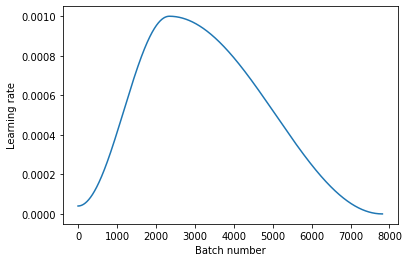

In [22]:
plot_lrs(history)

In [23]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in test_dl:
        images, labels = data
        outputs = model(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

In [24]:
# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 84.7 %
Accuracy for class: car   is 92.1 %
Accuracy for class: bird  is 75.8 %
Accuracy for class: cat   is 67.9 %
Accuracy for class: deer  is 81.3 %
Accuracy for class: dog   is 75.4 %
Accuracy for class: frog  is 87.0 %
Accuracy for class: horse is 86.6 %
Accuracy for class: ship  is 89.2 %
Accuracy for class: truck is 89.9 %


In [25]:
def predict(model, test_loader, device):
    
    # set model to evaluate model
    model.eval()
    
    y_true = torch.tensor([], dtype=torch.long, device=device)
    all_outputs = torch.tensor([], device=device)
    
    # deactivate autograd engine and reduce memory usage and speed up computations
    with torch.no_grad():
        for data in test_loader:
            inputs = [i.to(device) for i in data[:-1]]
            labels = data[-1].to(device)
            
            outputs = model(*inputs)
            y_true = torch.cat((y_true, labels), 0)
            all_outputs = torch.cat((all_outputs, outputs), 0)
    
    y_true = y_true.cpu().numpy()  
    _, y_pred = torch.max(all_outputs, 1)
    y_pred = y_pred.cpu().numpy()
    y_pred_prob = F.softmax(all_outputs, dim=1).cpu().numpy()
    
    return y_true, y_pred, y_pred_prob

In [26]:
y_true, y_pred, y_pred_prob = predict(model, test_dl, device)


 Model AUC 92.90%, Accuracy 82.99% on Test Data

              precision    recall  f1-score   support

       plane       0.85      0.85      0.85      1000
         car       0.92      0.92      0.92      1000
        bird       0.77      0.76      0.76      1000
         cat       0.67      0.68      0.67      1000
        deer       0.81      0.81      0.81      1000
         dog       0.78      0.75      0.76      1000
        frog       0.84      0.87      0.85      1000
       horse       0.88      0.87      0.87      1000
        ship       0.91      0.89      0.90      1000
       truck       0.89      0.90      0.89      1000

    accuracy                           0.83     10000
   macro avg       0.83      0.83      0.83     10000
weighted avg       0.83      0.83      0.83     10000



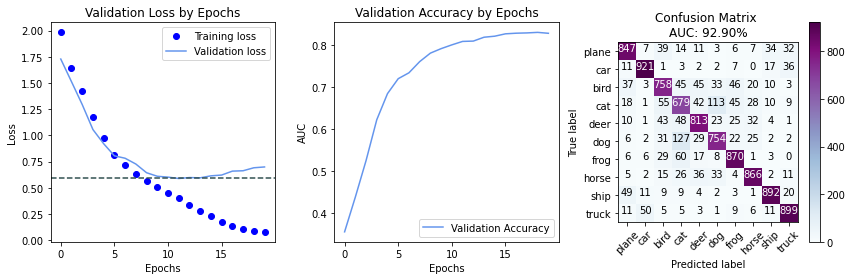

In [27]:
plot_training_metrics(history, model, test_data, y_true, y_pred, classes, model_name = "v2")

# Make predictions and see the image with its result


In [28]:
def predict_image(img, model):
    xb = to_device(img.unsqueeze(0), device)
    yb = model(xb)
    _, preds  = torch.max(yb, dim=1)
    return test_data.classes[preds[0].item()]

Label: cat , Predicted: cat


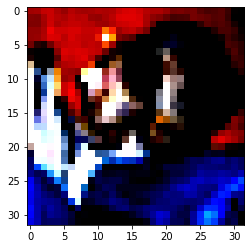

In [29]:
img, label = test_data[0]
plt.imshow(img.permute(1, 2, 0))
print('Label:', test_data.classes[label], ', Predicted:', predict_image(img, model))

Label: ship , Predicted: ship


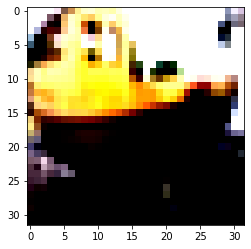

In [30]:
img, label = test_data[1002]
plt.imshow(img.permute(1, 2, 0))
print('Label:', test_data.classes[label], ', Predicted:', predict_image(img, model))

# Save

In [31]:
#torch.save(model.state_dict(), 'cifar_3conv_32batch_model.pth')

------

## RANDOM PICK FOR TOP 5

In [32]:
def find_prob(img, model):
    xb = to_device(img.unsqueeze(0), device)
    yb = model(xb)
    yb = F.softmax(yb, dim=1).cpu().detach().numpy()
    return yb

In [33]:
n_samples = 10000
random_index = int(np.random.random()*n_samples)
img, label = test_data[random_index]
y_query_prob = find_prob(img, model)
sorted_index = np.argsort(-1*y_query_prob)
print(f"Selected Query Image -> label_idx: {label}, label: {test_data.classes[label]}")
print("TOP 5 LABELS:")
for i in range(5):
    print(f"label_idx: {sorted_index[0][i]}, label: {test_data.classes[sorted_index[0][i]]}")

Selected Query Image -> label_idx: 2, label: bird
TOP 5 LABELS:
label_idx: 2, label: bird
label_idx: 6, label: frog
label_idx: 3, label: cat
label_idx: 4, label: deer
label_idx: 0, label: airplane
